In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import factorial

import pandas as pd
from sklearn.decomposition import PCA

# Helper function to load all data files
def loadFiles(files):
    nFeatures = []
    nCategories = []
    for file in files:
        # open [file]
        data_set = open(file, "r")
        
        # loop through each line of file
        for data_line in data_set: 
            data = data_line.rstrip().split(' ')
            
            nFeatures.append([float(i) for i in data[1:]])
            nCategories.append(file)
           
    return np.array(nFeatures), np.array(nCategories)

# helper function to calculate combination (nCr)
def nCombinationR(n , r):
    if(n < r):
        return 0
        
    return factorial(n) // factorial(r) // factorial(n - r)


In [3]:
class KMeansClustering:
    def __init__(self, k):
        self.k = k
        
    def fit_predict(self, data, norm=False, distance='euclidean'):
        
        # Set random seed
        np.random.seed(30)
        
        # Normalize Feature vector if norm == 'l2'
        if(norm == 'l2'):
            data = [ wordFeatures / np.sqrt(np.sum(wordFeatures ** 2)) for wordFeatures in data ]            

        # assign centroids to k vectors from the data
        self.cluster_centers_ = np.array([data[np.random.randint(0, len(data) - 1)] for _ in range(self.k)])
        
        optimized = False
        
        
        previousClassification = [ -1 for _ in range(len(data))]
        
        
        while optimized == False:
            
            # Initialize Values for classifications, cluster set and optimized flag
            classifications = []
            self.clusters = {i: [] for i in range(self.k)}
            optimized = True
            
            
            for idx, wordFeatures in enumerate(data):
                if distance == 'manhattan': # If distance == manhattan, use manhattan distance for the algorithm
                    distances = [
                        np.sum(np.abs( wordFeatures - centroid )) for centroid in self.cluster_centers_
                    ]
                elif distance == 'euclidean': # If distance == euclidean, use euclidean distance for the algorithm
                    distances = [
                        np.sqrt(np.dot(wordFeatures - centroid, wordFeatures - centroid)) for centroid in self.cluster_centers_
                    ]
                elif distance == 'cosine': # If distance == cosine, use cosine distance for the algorithm
                    distances = [
                        np.dot(wordFeatures, centroid) / (np.sqrt(np.dot(wordFeatures,wordFeatures)) * np.sqrt(np.dot(centroid,centroid))) for centroid in self.cluster_centers_
                    ]
                    
                if distance == 'cosine': # If distance == cosine, check the index with the highest cosine difference else check the one with the lowest and assign vector to that centroid
                    classification = distances.index(max(distances))
                else:
                    classification = distances.index(min(distances))
                
                # If any of the previous classification is not the same then the algorithm is not optimized, the algorithm terminates when the classification of all the feature vectors remain unchanged
                if previousClassification[idx] != classification:
                    optimized = False
                
                
                classifications.append(classification)
                
                # add feature vector to classification set
                self.clusters[classification].append(wordFeatures)
            
            # Calculates new points for the centroid by averaging as the vectors assigned to centroid
            for i in range(self.k):   
                if len(self.clusters[i]) > 0:
                    self.cluster_centers_[i] = np.array(np.average(self.clusters[i], axis = 0))
            
            previousClassification = classifications
        
        return np.array(previousClassification)
    
    def evaluate_clustering(self, categories, clusters, category_names = ["animals", "countries", "fruits", "veggies"]):

        TP = 0
        FN = 0
        TPFP = 0
        
        
        frequencyDistribution = np.array([[0 for _ in range(self.k)] for _ in range(len(category_names))])
        
        # Populate Frequency Distribution Table (2D array) to calculate True positive, True negative, False Positive, False negative
        for i in range(len(categories)):
            frequencyDistribution[category_names.index(categories[i])][clusters[i]] += 1 
        
        for fd in frequencyDistribution:
            for c in combinations(fd, 2):
                FN += c[0] * c[1]

            for frequency in fd:
                TP += nCombinationR(frequency, 2)
                    
        for nTotal in frequencyDistribution.sum(axis=0):
            TPFP += nCombinationR(nTotal, 2)
        
        # Calculate 
        P = TP / TPFP
        
        # Calculate 
        R = TP / ( TP + FN )
        
        #Calculate
        F = ( 2 * P * R ) / ( P + R )


        return P, R, F
       


In [4]:
files = ["animals", "countries", "fruits", "veggies"]

nFeatures, nCategories  = loadFiles(files)
print(nFeatures)
print(nCategories)

[[-0.015926  -0.079864  -0.33218   ... -0.023002   0.0039075 -0.035713 ]
 [ 0.47727   -0.91587   -0.2977    ... -0.44699   -0.24957    0.02851  ]
 [-0.33575    0.38897   -0.41929   ... -0.14929   -0.23516    0.039194 ]
 ...
 [-0.36216   -0.5386    -0.66052   ...  0.026223   0.14061   -0.38506  ]
 [-0.14323   -0.31758   -0.39174   ... -0.56286   -0.58964    0.25269  ]
 [-0.58577   -0.37071   -0.12452   ... -0.0054729 -0.84361    0.087304 ]]
['animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'animals' 'animals' 'animals' 'animals' 'animals' 'animals'
 'animals' 'countries' 'countries' 'countries' 'countries' 

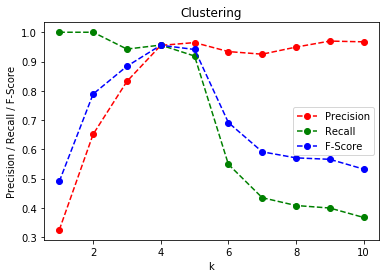

In [5]:
Indexes = []
nPrecision = []
nRecall = []
nFScore = []

for k in range(1, 11):
    
    kMeans = KMeansClustering(k)
    clusters = kMeans.fit_predict(nFeatures)
    
    P, R, F = kMeans.evaluate_clustering(nCategories, clusters)
    
    Indexes.append(k)
    nPrecision.append(P)
    nRecall.append(R)
    nFScore.append(F)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Indexes, nPrecision, '--o', color='red', label='Precision')
ax.plot(Indexes, nRecall, '--o', color='green', label='Recall')
ax.plot(Indexes, nFScore, '--o', color='blue', label='F-Score')

plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('Precision / Recall / F-Score')
plt.legend()
plt.show()


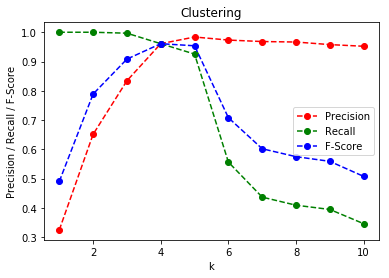

In [6]:
Indexes = []
nPrecision = []
nRecall = []
nFScore = []

for k in range(1, 11):
    
    kMeans = KMeansClustering(k)
    clusters = kMeans.fit_predict(nFeatures, norm='l2')
    P, R, F = kMeans.evaluate_clustering(nCategories, clusters)
    
    Indexes.append(k)
    nPrecision.append(P)
    nRecall.append(R)
    nFScore.append(F)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Indexes, nPrecision, '--o', color='red', label='Precision')
ax.plot(Indexes, nRecall, '--o', color='green', label='Recall')
ax.plot(Indexes, nFScore, '--o', color='blue', label='F-Score')

plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('Precision / Recall / F-Score')
plt.legend()
plt.show()

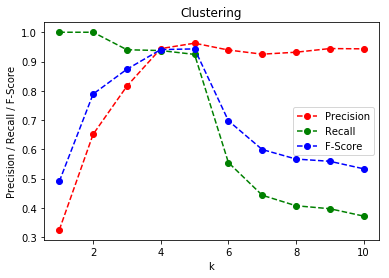

In [7]:
Indexes = []
nPrecision = []
nRecall = []
nFScore = []

for k in range(1, 11):
    
    kMeans = KMeansClustering(k)
    clusters = kMeans.fit_predict(nFeatures, distance='manhattan')
    P, R, F = kMeans.evaluate_clustering(nCategories, clusters)
    
    Indexes.append(k)
    nPrecision.append(P)
    nRecall.append(R)
    nFScore.append(F)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Indexes, nPrecision, '--o', color='red', label='Precision')
ax.plot(Indexes, nRecall, '--o', color='green', label='Recall')
ax.plot(Indexes, nFScore, '--o', color='blue', label='F-Score')

plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('Precision / Recall / F-Score')
plt.legend()
plt.show()

0.32485729112610273 1.0 0.49040344692518606
0.6514047866805411 1.0 0.7889098928796472
0.8298488417746368 0.9646850753080785 0.8922013507809201
0.9610137564929505 0.960520310360566 0.9607669700687649
0.9844634469468867 0.9326791419443177 0.9578719165641296
0.9745210349595101 0.5629849383842994 0.7136761408837781
0.9680930002473411 0.4465997261524418 0.6112282345592254
0.9612619808306709 0.4119694203560018 0.5767571884984025
0.9607710058368399 0.4038110451848471 0.568628238602129
0.9542141951837769 0.3436216339570972 0.5052852348993289


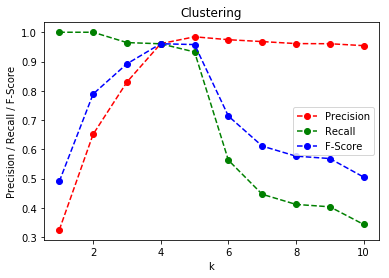

In [8]:
Indexes = []
nPrecision = []
nRecall = []
nFScore = []

for k in range(1, 11):
    
    kMeans = KMeansClustering(k)
    clusters = kMeans.fit_predict(nFeatures, distance='manhattan' , norm='l2')
    P, R, F = kMeans.evaluate_clustering(nCategories, clusters)
    print(P, R, F)
    Indexes.append(k)
    nPrecision.append(P)
    nRecall.append(R)
    nFScore.append(F)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Indexes, nPrecision, '--o', color='red', label='Precision')
ax.plot(Indexes, nRecall, '--o', color='green', label='Recall')
ax.plot(Indexes, nFScore, '--o', color='blue', label='F-Score')

plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('Precision / Recall / F-Score')
plt.legend()
plt.show()

0.32485729112610273 1.0 0.49040344692518606
0.6514047866805411 1.0 0.7889098928796472
0.8342382164993033 0.9905864901871292 0.9057145092720587
0.9665049928673324 0.9663395709721588 0.966422274840955
0.9803089972735535 0.9230944774075764 0.9508418299885406
0.967587513712975 0.5535143769968051 0.704191616766467
0.9589594645788609 0.43324965769055224 0.596848351475616
0.9691325172964342 0.4155636695572798 0.5816962146621946
0.9656292286874154 0.40712003651300777 0.5727586483666426
0.9602379461490295 0.34995435874030123 0.5129620337849139


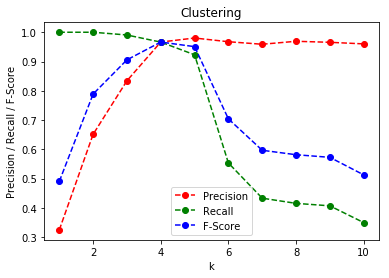

In [9]:
Indexes = []
nPrecision = []
nRecall = []
nFScore = []

for k in range(1, 11):
    
    kMeans = KMeansClustering(k)
    clusters = kMeans.fit_predict(nFeatures, distance='cosine')
    P, R, F = kMeans.evaluate_clustering(nCategories, clusters)
    print(P, R, F)
    Indexes.append(k)
    nPrecision.append(P)
    nRecall.append(R)
    nFScore.append(F)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Indexes, nPrecision, '--o', color='red', label='Precision')
ax.plot(Indexes, nRecall, '--o', color='green', label='Recall')
ax.plot(Indexes, nFScore, '--o', color='blue', label='F-Score')

plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('Precision / Recall / F-Score')
plt.legend()
plt.show()

In [10]:
nClusters = 4
kMeans = KMeansClustering(nClusters)

table = pd.DataFrame(nFeatures)
table['category'] = nCategories
table['cluster'] = kMeans.fit_predict(nFeatures)
P, R, F = kMeans.evaluate_clustering(nCategories, table['cluster'])
table

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,category,cluster
0,-0.015926,-0.079864,-0.332180,0.034246,0.110450,0.060519,-1.183000,-0.709950,-0.153610,-0.174460,...,0.086454,0.244950,-0.621270,0.377990,0.709060,-0.023002,0.003908,-0.035713,animals,1
1,0.477270,-0.915870,-0.297700,-0.224890,0.553370,0.177720,-1.560300,-0.405800,-0.375230,-0.304880,...,0.312520,0.162300,0.022012,0.048974,-0.027862,-0.446990,-0.249570,0.028510,animals,1
2,-0.335750,0.388970,-0.419290,-0.332190,0.531700,-0.258390,-2.386900,-0.434430,-0.397600,-0.993560,...,0.484270,0.251670,-0.068426,0.342270,0.268400,-0.149290,-0.235160,0.039194,animals,1
3,0.211100,0.217630,-0.526380,-0.422770,0.846720,-0.038383,-1.920100,-0.309590,0.021942,-0.495250,...,0.632910,-0.321110,-0.046260,-0.179710,-0.001380,-0.150760,-0.240640,-0.051365,animals,1
4,0.081110,-0.502850,-0.055975,0.459650,-0.302710,0.066912,0.130840,-0.404260,-0.290590,-0.080720,...,-0.475560,-0.469140,-0.131460,0.285380,-0.051485,-0.400790,0.231430,0.229130,animals,1
5,0.523750,-0.088009,-0.340410,0.227460,0.156960,-0.612600,-1.617600,0.083366,-0.057816,-0.013898,...,-0.206540,-0.285540,-0.342760,0.143320,-0.276130,-0.419690,0.045825,-0.086117,animals,1
6,0.024381,-0.257040,-0.174840,0.159500,-0.100390,-0.140130,-0.149750,-0.098324,0.137710,-0.323340,...,-0.637660,0.276660,-0.159110,0.376680,0.907500,-0.044400,-0.302470,0.180840,animals,1
7,-0.410440,-0.195970,-0.012241,0.083717,-0.597950,-0.107260,-2.054200,-0.285230,0.322170,-0.800380,...,0.067010,0.526360,-0.153880,-0.021983,0.395530,-0.331710,-0.045919,0.313220,animals,1
8,-0.233680,0.128230,-0.131860,0.562260,0.729040,0.076742,-1.655400,-0.086032,-0.418830,-0.057504,...,-0.123980,-0.129580,0.348370,-0.171670,0.262880,-0.208730,0.091751,0.503050,animals,1
9,0.070648,-0.578510,-0.907260,0.102150,0.691480,0.040074,-1.197300,-0.652870,-0.175300,-0.243110,...,0.195510,-0.128180,-0.272710,-0.067378,0.296410,0.226800,-0.023719,0.538860,animals,1


In [11]:
pca = PCA(n_components = 2)
table['x'] = pca.fit_transform(nFeatures)[:,0]
table['y'] = pca.fit_transform(nFeatures)[:,1]

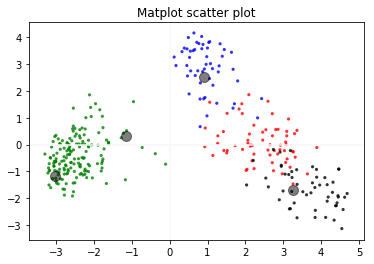

In [12]:
colors = ['red', 'blue', 'green', 'black', '#BBD8B3', '#F3B61F', '#A29F15', '#510D0A', '#191102', '#F45D01']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for n in range(nClusters): 
    ax.scatter(
        table[table.cluster == n]['x'], 
        table[table.cluster == n]['y'], 
        alpha=0.8,
        c=colors[n], 
        edgecolors='none', 
        s=10
    )

centers = pca.fit_transform(kMeans.cluster_centers_)
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)


plt.title('Matplot scatter plot')
plt.axhline(0, color='#f8f8f8')
plt.axvline(0, color='#f8f8f8')
plt.show()